In [111]:
#General imports
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pathlib
from pathlib import Path
import h5py
import glob

import pandas as pd

#scipy's fourier stuff
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

In [112]:
#Set Data Directories and create iterator over 
# hdf5 files for train and test datasets....

#path to data
dataDir = "/Users/DavidRimel/Desktop/CMSE890/Project/projectData/"
test_file = "single_test_knee/singlecoil_test" #"knee_multicoil_test_v2.tar.gz"
train_file = "single_val_knee/singlecoil_val" #"multicoil_val.tar.gz"

def hdf5_iter(Dir):
    return glob.iglob(dataDir+Dir+'/*.h5')

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00017707173297391214, 'norm': 0.058663394182755665, 'patient_id': 'b2a82c7521fe2d4aebb627bbaae92a1916bf06e75cb374fc4187b0909e5c0e36'}
320
160
480
160


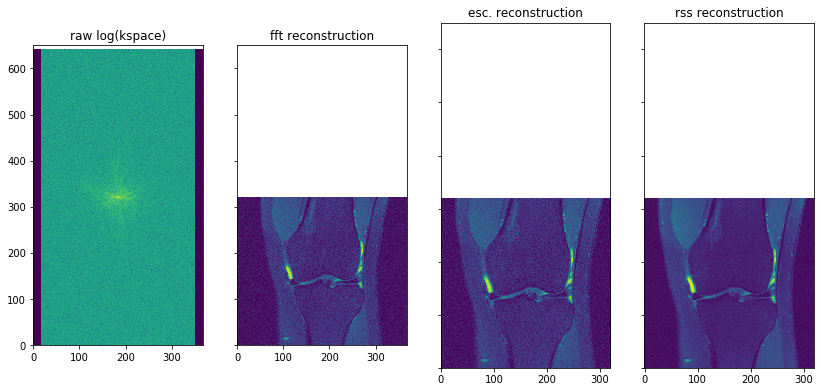

In [ ]:
#Data Exploration just getting a sense of what features my data has...

test_file = "/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000000.h5"
hf = h5py.File(test_file)
volume_kspace = hf['kspace'][()]
X_shape = volume_kspace.shape
slice_num = volume_kspace.shape[0]//2

hf = h5py.File(test_file)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]
volume_esc_recon = hf['reconstruction_esc'][()]
volume_rss_recon = hf['reconstruction_rss'][()]
del_img=volume_rss_recon.shape[1]//2

fig, ax = plt.subplots(1, 4, sharey=True,figsize=(14,14))
ax[0].imshow(np.log(np.abs(volume_kspace[slice_num])+1e-9))
ax[0].set_title("raw log(kspace)")
ax[0].set_ylim(0,650)
s_ksp = volume_kspace[slice_num]
s_ksp1 = ifftshift(ifft2(s_ksp))
c = (s_ksp1.shape[0]//2)
print(c)
print(del_img)
print(c+del_img)
print(c-del_img)
ax[1].imshow(np.abs(s_ksp1)[c-del_img:c+del_img,:])
ax[1].set_title("fft reconstruction")
ax[2].imshow(volume_esc_recon[slice_num])
ax[2].set_title("esc. reconstruction")
ax[3].imshow(volume_rss_recon[slice_num])
ax[3].set_title("rss reconstruction")
plt.show()


fig, ax = plt.subplots(1, 2, sharey=True,figsize=(14,14))
st_real = volume_esc_recon[slice_num]
st_ksp1 = ifftshift(fft2(st_real))
ax[0].imshow(st_real)
ax[1].imshow(np.log(np.abs(st_ksp1)+1e-9))
plt.show()

print(st_ksp1.shape)

X_shape = st_real.shape
y_shape = volume_rss_recon[slice_num].shape
print("Train_kspace shape (X_df) = " + str(X_shape))
print("Train_truth shape (y_df) = " + str(y_shape))

In [98]:
# Sort Train data into pandas DataFrames

hf = h5py.File("/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_train_knee/singlecoil_train/file1000001.h5")
volume_kspace = hf['kspace'][()]
train_shape = volume_kspace.shape
slice_num = train_shape[0]//2 #middle slice..

df_ksp = []
df_fftskp = []
df_truth = []
X = []
y = []

for h5 in hdf5_iter(train_file):
    
    print(h5)
    
    hf = h5py.File(h5)
    
    #for some reason one of the files is missing this attribute so just skip it...
    if ('kspace'  in hf.keys() ) and ('reconstruction_esc'  in hf.keys()) and ('reconstruction_rss' in hf.keys()):
    
        #grab slice by the slice num found above and flatten
        #volume_kspace = hf['kspace'][()]
        volume_esc_recon = hf['reconstruction_esc'][()]
        volume_rss_recon = hf['reconstruction_rss'][()]
        slice_esc_recon = volume_esc_recon[slice_num-2:slice_num+2+1]
        slice_rss_recon = volume_rss_recon[slice_num-2:slice_num+2+1]
        slice_kspace = np.abs(ifftshift(fft2(slice_esc_recon))) #need this to be real..
        #kspace_row = slice_kspace.flatten() 
        #esc_row = slice_esc_recon.flatten() 
        #rss_row = slice_rss_recon.flatten() 
    
        #add to List for dictionary
        #df_ksp.append(kspace_row)
        #df_fftskp.append(esc_row)
        #df_truth.append(rss_row)
        #X.append(slice_kspace)
        X.append(slice_esc_recon)
        y.append(slice_rss_recon)
    
    
    hf.close()
    
X = np.array(X)
y = np.array(y)
X_dict = { "kspace freq":df_ksp , "FFT(kspace) real":df_fftskp }
y_dict = { "Ground Truth real":df_truth }
#X_df = pd.DataFrame(data=X_dict)
#y_df = pd.DataFrame(data=y_dict)

/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000000.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000007.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000017.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000026.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000031.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000033.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000041.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000052.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000071.h5
/Users/DavidRimel/Desktop/CMSE890/Project/projectData/single_val_knee/singlecoil_val/file1000073.h5


In [104]:
#print(X_df.iloc[3,:])
#print(y_df.iloc[3,:].to_numpy())
#print(y_df.iloc[3,:].to_numpy())
X_n = X.reshape(X.shape[0]*X.shape[1],320,320,1)
y_n = y.reshape(y.shape[0]*y.shape[1],320,320,1)
print(X_n.shape)
print(y_n.shape)

(790, 320, 320, 1)
(790, 320, 320, 1)


In [105]:
#define the Unet Model
def Unet(X_shape):
    input_layer = Input(X_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'relu')(conv9)

    model = Model(inputs=input_layer, outputs = conv10)

    model.compile(optimizer = Adam(lr = 0.001), loss = tf.keras.losses.mean_absolute_error, metrics = ['accuracy'])
    
    model.summary()

    return model

In [107]:
unet_model = Unet(X_n[0].shape)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_265 (Conv2D)             (None, 320, 320, 64) 640         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_266 (Conv2D)             (None, 320, 320, 64) 36928       conv2d_265[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_44 (MaxPooling2D) (None, 160, 160, 64) 0           conv2d_266[0][0]                 
___________________________________________________________________________________________

In [110]:
#fit Unet Model
niter = 40 #epochs
unet_model.fit(X_n,y_n, batch_size=20, epochs=niter)

Train on 790 samples
Epoch 1/40
260/790 [========>.....................] - ETA: 32:14 - loss: 6.8100e-09 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [109]:
p = unet_model.predict(X_new[0,:,:,:])
plt.imshow(X_new[0,:,:,:].reshape(320, 320))